# 0. Importing the necessary libraries and the dataset

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
pip install tokenization

In [3]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [4]:
pip install bert-tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.4 MB/s eta 0:00:00


In [5]:
from bert import tokenization

In [6]:
from google.colab import drive
drive.mount('/content/drive')

%ls /content/drive/My\ Drive/CSCI594/Project

df_train = pd.read_csv('/content/drive/My Drive/CSCI594/Project/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('/content/drive/My Drive/CSCI594/Project/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Mounted at /content/drive
'Copy_of_nlp_with_disaster_tweets_eda_cleaning_and_bert (1).ipynb'
'Copy of nlp-with-disaster-tweets-eda-cleaning-and-bert.ipynb'
 crawl-300d-2M.pkl
'Final_ver_of_nlp_with_disaster_tweets_eda_cleaning_and_bert_(3).ipynb'
 glove.840B.300d.pkl
 nlp-with-disaster-tweets-eda-cleaning-and-bert.ipynb
 test.csv
 train.csv
 Untitled0.ipynb
'useful links.gdoc'
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train['text'][11]

'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding'

## **1. Dataset**

### **1.1 Missing Values**

After studying both training and test sets, the presence of missing values in the `keyword` and `location` columns were observed. It was further confirmed by bar charts and the NaN values were renamed for the convenient analysis as `missing_keyword` and `missing_location`. The following observations were also made for both training and test sets, dedicating that they come from the same sample:

* `keyword` column has missing values of approximately **0.08%**
* `location` column has missing values of approximately **33.5%**


Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


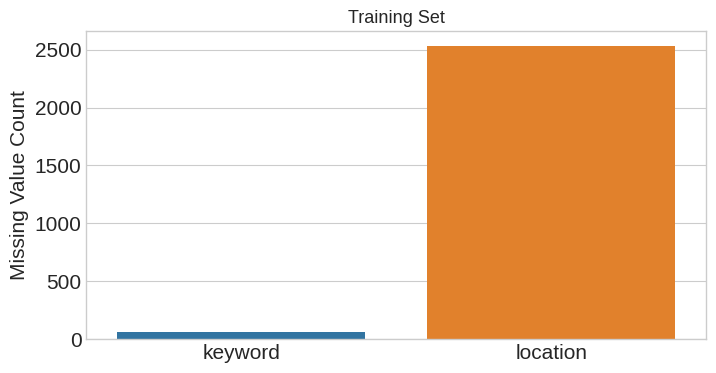

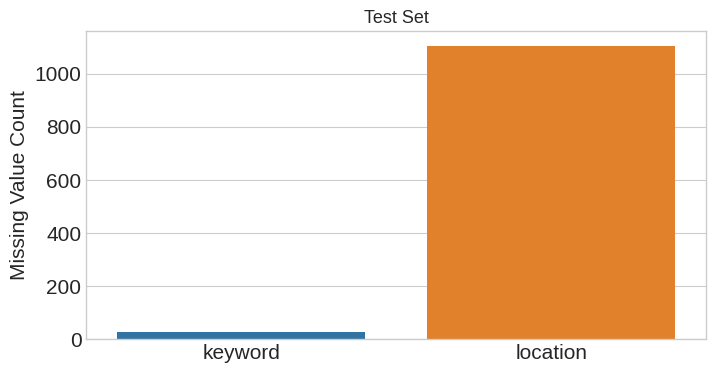

In [9]:
MISSING_COLS = ['keyword', 'location']

# Data Loading
df_train = pd.read_csv('/content/drive/My Drive/CSCI594/Project/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('/content/drive/My Drive/CSCI594/Project/test.csv', dtype={'id': np.int16})

# Function Definitions
def print_dataset_info(df, dataset_name):
    print(f'{dataset_name} Set Shape = {df.shape}')
    print(f'{dataset_name} Set Memory Usage = {df.memory_usage().sum() / 1024**2:.2f} MB')

def plot_missing_values(df, dataset_name):
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(8, 4), dpi=100)
        sns.barplot(x=df[MISSING_COLS].isnull().sum().index, y=df[MISSING_COLS].isnull().sum().values)
        plt.ylabel('Missing Value Count', size=15)
        plt.xticks(size=15)
        plt.yticks(size=15)
        plt.title(f'{dataset_name} Set', fontsize=13)
        plt.show()

# Main Execution
print_dataset_info(df_train, 'Training')
print_dataset_info(df_test, 'Test')

plot_missing_values(df_train, 'Training')
plot_missing_values(df_test, 'Test')

#Fill missing values
df_train['keyword'].fillna('missing_keyword', inplace=True)
df_train['location'].fillna('missing_location', inplace=True)
df_test['keyword'].fillna('missing_keyword', inplace=True)
df_test['location'].fillna('missing_location', inplace=True)

In [10]:
df_train[df_train['keyword'] == 'missing_keyword'].shape[0] / df_train.shape[0]

0.008012610009194798

In [11]:
df_train[df_train['location'] == 'missing_location'].shape[0] / df_train.shape[0]

0.33272034677525286

In [12]:
df_test[df_test['keyword'] == 'missing_keyword'].shape[0] / df_test.shape[0]

0.00796812749003984

In [13]:
df_test[df_test['location'] == 'missing_location'].shape[0] / df_test.shape[0]

0.3386454183266932

### **1.2 Distribution of values**

Judging from the number of unique `keyword` values, each of the training and test sets have the same set of them. It can be used as a feature based on its cleanliness seen from the output of `value_counts`.

Regarding `location` values, the huge number of unique instances indeed shows that they were inputs given by users. This column contains many inconsistent values such as 'MontrÌ©al, QuÌ©bec', so it can't be used as a feature.

In [14]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


In [15]:
df_train['keyword'].value_counts()

missing_keyword          61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
harm                     41
body%20bags              41
evacuate                 40
fear                     40
outbreak                 40
siren                    40
twister                  40
windstorm                40
collided                 40
sinkhole                 39
sunk                     39
hellfire                 39
weapon                   39
weapons                  39
famine                   39
explosion                39
whirlwind                39
earthquake               39
derailment               39
wreckage                 39
collision                39
flames                   39
wrecked                  39
ambulance                38
injury                   38
hurricane                38
flooding                 38
fire                     38
fatal                    38
blaze               

In [16]:
df_train['location'].value_counts()

missing_location                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

To see the most common `keyword` and `location` values, barplot of the most 10 common values in each of these columns were made.

As expected, `keyword` column most frequently contains most common words related to natural disasters. Unfortunately, there is a considerably high number of `missing_keyword` values in this column.

`location` column shows some inconsistencies such as 'USA'. 'United States' and 'Los Angeles, CA' were being used as separate locations, showing some room for improvement. What is the most problematic is the majority of values in this column being `missing_location`, making this column even less relevant as a feature.

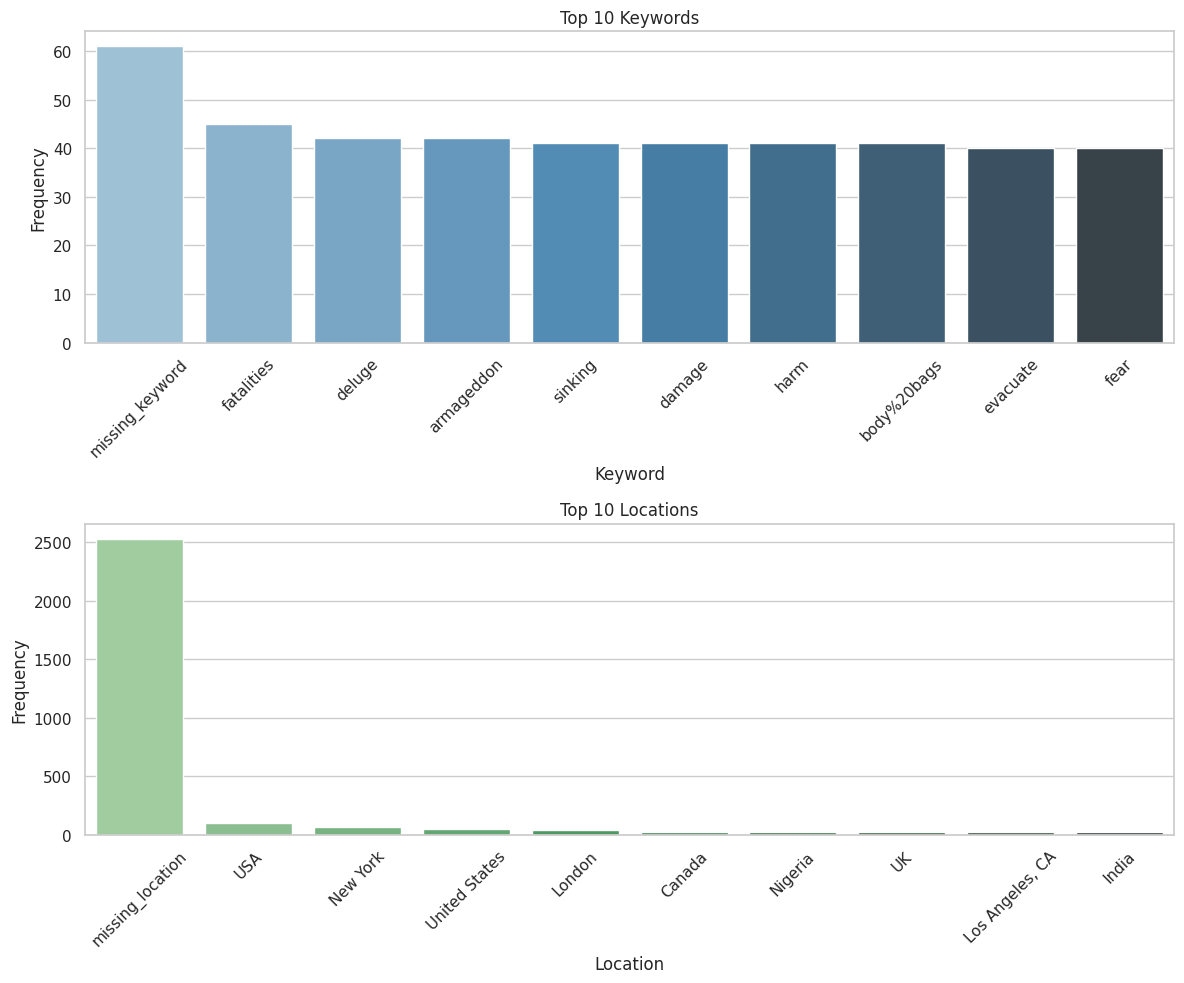

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_train is your DataFrame

# Set aesthetic parameters in one step
sns.set(style="whitegrid")

# Data Preparation for Keywords
top_keywords = df_train['keyword'].value_counts().head(10)
top_locations = df_train['location'].value_counts().head(10)

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# Bar Chart for Keywords
sns.barplot(x=top_keywords.index, y=top_keywords.values, ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 10 Keywords')
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Keyword')
axes[0].tick_params(axis='x', rotation=45)

# Bar Chart for Locations
sns.barplot(x=top_locations.index, y=top_locations.values, ax=axes[1], palette="Greens_d")
axes[1].set_title('Top 10 Locations')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Location')
axes[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### **1.3 Distribution of targets**

Seeing from the pie chart and bar charts for the `target` column, the distribution of the values for this column is observed. It is depicted to be as follows:

* **0** (**Not Disaster**) - 57.0% of values;
* **1** (**Disaster**) - 43.0% of values;

*Balanced classes* are observed so there is a low risk of bias, stratification is less critical in cross-validation and standard performance metrics are reliable.

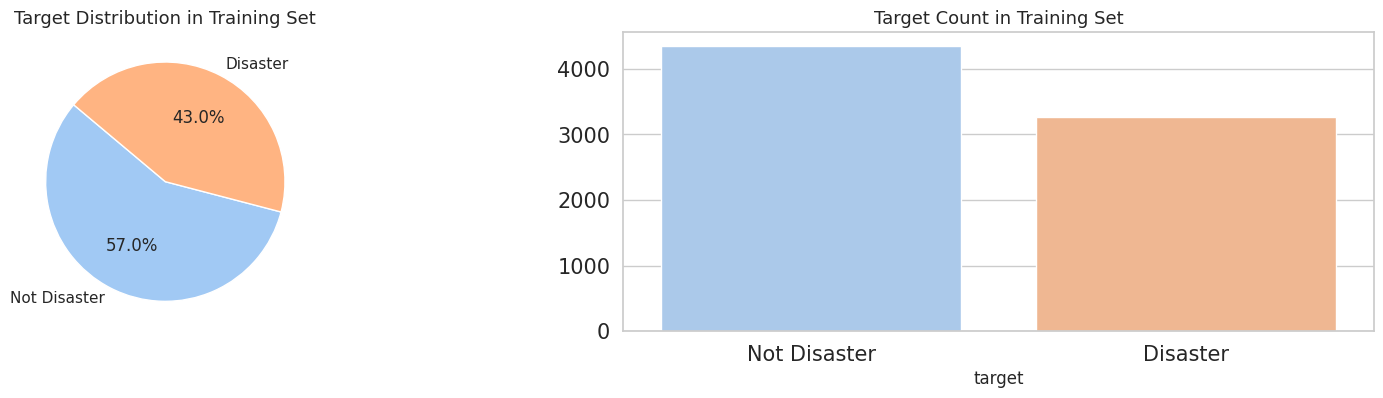

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def customize_axis(ax, title, xticklabels=None):
    """Customize each subplot axis."""
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    if xticklabels:
        ax.set_xticklabels(xticklabels)
    ax.set_ylabel('')

# Set the overall style and layout
sns.set(style="whitegrid")
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout(pad=2)

# Data Preparation
target_counts = df_train['target'].value_counts()
target_labels = ['Not Disaster', 'Disaster']
colors = sns.color_palette('pastel')[0:2]

# Pie Chart
axes[0].pie(target_counts, labels=target_labels, autopct='%1.1f%%', startangle=140, colors=colors)
customize_axis(axes[0], 'Target Distribution in Training Set')

# Bar Chart
sns.countplot(x='target', data=df_train, ax=axes[1], palette=colors)
customize_axis(axes[1], 'Target Count in Training Set', ['Not Disaster', 'Disaster'])

# Display the plot
plt.show()

## **2. Embeddings and Text Cleaning**

### **2.1 Embeddings Coverage**
Train and test vocabs are created through counting the number of words in `text` column for tweets, for the purpose of obtaining vocabulary maximally close to embeddings. In this project, the following embeddings are used for text cleaning:

* GloVe-300d-840B
* FastText-Crawl-300d-2M

In [19]:
%%time

glove_embeddings = np.load('/content/drive/My Drive/CSCI594/Project/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('/content/drive/My Drive/CSCI594/Project/crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 13.9 s, sys: 6.1 s, total: 20 s
Wall time: 1min 21s


Embedding is applied through `build_vocab` and `check_embeddings_coverage`functions.

`covered` is used to store the words that are in the intersection of embeddings and vocab. `n_covered`stands for total number of them.

`oov` is used to store the words that are in vocab but not in embeddings. `n_oov` stands for total number of them.

To calculate the coverage percentages, `n_covered` and `n_oov` are used. Without cleaning, both GloVe and FastTextCrawl embeddings have vocabulary coverage higher than **50%** and text coverage higher than **80%**. Even though both embeddings have approximately close coverage values, GloVe has higher percentages.

In [20]:
from collections import defaultdict, Counter
from typing import Dict, List, Tuple

def build_vocab(tweets: pd.Series) -> Dict[str, int]:
    """Build vocabulary from a series of tweets."""
    vocab = Counter()
    for tweet in tweets:
        if tweet:  # Ensure tweet is not None or empty
            words = tweet.split()
            vocab.update(words)
    return vocab

def check_embeddings_coverage(tweets, embeddings):
    """Check how much of the vocabulary and text the embeddings cover."""
    vocab = build_vocab(tweets)
    covered = {word: count for word, count in vocab.items() if word in embeddings}
    out_of_vocab = {word: count for word, count in vocab.items() if word not in embeddings}

    n_covered = sum(covered.values())
    n_oov = sum(out_of_vocab.values())

    # Check if vocab is not empty to avoid ZeroDivisionError
    vocab_coverage = len(covered) / len(vocab) if len(vocab) > 0 else 0
    text_coverage = n_covered / (n_covered + n_oov) if (n_covered + n_oov) > 0 else 0

    sorted_oov = sorted(out_of_vocab.items(), key=lambda item: item[1], reverse=True)

    return sorted_oov, vocab_coverage, text_coverage

# GloVe Coverage
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)

# FastText Coverage
train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)

# Reporting Coverage
print(f'GloVe Embeddings cover {train_glove_vocab_coverage:.2%} of vocabulary and {train_glove_text_coverage:.2%} of text in Training Set')
print(f'GloVe Embeddings cover {test_glove_vocab_coverage:.2%} of vocabulary and {test_glove_text_coverage:.2%} of text in Test Set')
print(f'FastText Embeddings cover {train_fasttext_vocab_coverage:.2%} of vocabulary and {train_fasttext_text_coverage:.2%} of text in Training Set')
print(f'FastText Embeddings cover {test_fasttext_vocab_coverage:.2%} of vocabulary and {test_fasttext_text_coverage:.2%} of text in Test Set')


GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set
FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


### **2.2 Text Cleaning**
Text cleaning: `clean()` function dealing with (using ReGex)

* Special characters that are attached to words (`#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;`) removed completely;
* Contractions are expanded;
* Urls are removed;
* Character entity references are replaced with their actual symbols;
* Typos and slang are corrected, and informal abbreviations are written in their long forms;
* Some words are replaced with their acronyms and some words are grouped into one;
* Expanding informational usernames and hashtags as much as possible;


In [21]:
import re

# Pre-compile the patterns
regex_patterns = {
    'special_characters': re.compile(r"[\x89Û_\x89ÛÒ\x89ÛÓ\x89ÛÏ\x89Ûª\x89Û\x9då_\x89Û¢åÊåÊåÈ]"),
    'contractions': re.compile(r"(he's|there's|We're|That's|won't|they're|Can't|wasn't|don\x89Ûªt|aren't|isn't|What's|haven't|hasn't|There's|He's|It's|You're|I'M|shouldn't|wouldn't|i'm|I\x89Ûªm|I'm|Isn't|Here's|you've|you\x89Ûªve|we're|what's|couldn't|we've|it\x89Ûªs|doesn\x89Ûªt|It\x89Ûªs|Here\x89Ûªs|who's|I\x89Ûªve|y'all|can\x89Ûªt|would've|it'll|we'll|wouldn\x89Ûªt|We've|he'll|Y'all|Weren't|Didn't|they'll|they'd|DON'T|That\x89Ûªs|they've|i'd|should've|You\x89Ûªre|where's|Don\x89Ûªt|we'd|i'll|weren't|They're|Can\x89Ûªt|you\x89Ûªll|I\x89Ûªd|let's|it's|can't|don't|you're|i've|that's|i'll|doesn't|i'd|didn't|ain't|you'll|I've|Don't|I'll|I'd|Let's|you'd|It's|Ain't|Haven't|Could've|youve|donå«t)", re.IGNORECASE),
    'character_entity': re.compile(r"&gt;|&lt;|&amp;"),
    'url': re.compile(r"https?:\/\/t.co\/[A-Za-z0-9]+"),
    'user_handle': re.compile(r"@\w+"),
    'hashtag': re.compile(r"#\w+"),
    'acronyms': re.compile(r"MH370|mÌ¼sica|okwx|arwx|gawx|scwx|cawx|tnwx|azwx|alwx|wordpressdotcom|usNWSgov|Suruc|Bestnaijamade|SOUDELOR")
}

contractions_dict = {
    "he's": "he is",
    "there's": "there is",
    "We're": "We are",
    "That's": "That is",
    # Add all contractions replacements here
}

import re

def clean(tweet):
    if tweet is None:  # Check if tweet is None
        return ''

    # Handling special characters and contractions
    special_chars = {
        r"\x89Û_": "", r"\x89ÛÒ": "", r"\x89ÛÓ": "", r"\x89ÛÏWhen": "When",
        r"\x89ÛÏ": "", r"China\x89Ûªs": "China's", r"let\x89Ûªs": "let's",
        r"\x89Û÷": "", r"\x89Ûª": "", r"\x89Û\x9d": "", r"å_": "",
        r"\x89Û¢": "", r"\x89Û¢åÊ": "", r"fromåÊwounds": "from wounds",
        r"åÊ": "", r"åÈ": "", r"JapÌ_n": "Japan", r"Ì©": "e", r"å¨": "",
        r"SuruÌ¤": "Suruc", r"åÇ": "", r"å£3million": "3 million", r"åÀ": ""
    }

    for pattern, repl in special_chars.items():
        tweet = re.sub(pattern, repl, tweet)

    # Replacing contractions and similar patterns
    contractions = {
        r"he's": "he is", r"there's": "there is", r"We're": "We are",
        r"That's": "That is", r"won't": "will not", r"they're": "they are",
        r"Can't": "Cannot", r"wasn't": "was not",
        r"don\x89Ûªt": "do not", r"aren't": "are not",
        r"isn't": "is not", r"What's": "What is",
        r"haven't": "have not", r"hasn't": "has not",
        r"There's": "There is", r"He's": "He is",
        r"It's": "It is", r"You're": "You are",
        r"I'M": "I am", r"shouldn't": "should not",
        r"wouldn't": "would not", r"i'm": "I am",
        r"I\x89Ûªm": "I am", r"I'm": "I am",
        r"Isn't": "is not", r"Here's": "Here is",
        r"you've": "you have", r"you\x89Ûªve": "you have",
        r"we're": "we are", r"what's": "what is",
        r"couldn't": "could not", r"we've": "we have",
        r"it\x89Ûªs": "it is", r"doesn\x89Ûªt": "does not",
        r"It\x89Ûªs": "It is", r"Here\x89Ûªs": "Here is",
        r"who's": "who is", r"I\x89Ûªve": "I have",
        r"y'all": "you all", r"can\x89Ûªt": "cannot",
        r"would've": "would have", r"it'll": "it will",
        r"we'll": "we will", r"wouldn\x89Ûªt": "would not",
        r"We've": "We have", r"he'll": "he will",
        r"Y'all": "You all", r"Weren't": "Were not",
        r"Didn't": "Did not", r"they'll": "they will",
        r"they'd": "they would", r"DON'T": "DO NOT",
        r"That\x89Ûªs": "That is", r"they've": "they have",
        r"i'd": "I would", r"should've": "should have",
        r"You\x89Ûªre": "You are", r"where's": "where is",
        r"Don\x89Ûªt": "Do not", r"we'd": "we would",
        r"i'll": "I will", r"weren't": "were not",
        r"They're": "They are", r"Can\x89Ûªt": "Cannot",
        r"you\x89Ûªll": "you will", r"I\x89Ûªd": "I would",
        r"let's": "let us", r"it's": "it is",
        r"can't": "cannot", r"don't": "do not",
        r"you're": "you are", r"i've": "I have",
        r"that's": "that is", r"i'll": "I will",
        r"doesn't": "does not", r"i'd": "I would",
        r"didn't": "did not", r"ain't": "am not",
        r"you'll": "you will", r"I've": "I have",
        r"Don't": "do not", r"I'll": "I will",
        r"I'd": "I would", r"Let's": "Let us",
        r"you'd": "You would", r"It's": "It is",
        r"Ain't": "am not", r"Haven't": "Have not",
        r"Could've": "Could have", r"youve": "you have",
        r"donå«t": "do not"
    }

    for pattern, repl in contractions.items():
        tweet = re.sub(pattern, repl, tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Handling URLs
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Replace words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # Handling "..." and ".."
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Normalize whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet

# Fill NA values with empty strings before applying the clean function
df_train['text'].fillna('', inplace=True)
df_test['text'].fillna('', inplace=True)

# Apply cleaning function and ensure the result is a string
df_train['text_cleaned'] = df_train['text'].apply(lambda s: clean(s) if pd.notnull(s) else "")
df_test['text_cleaned'] = df_test['text'].apply(lambda s: clean(s) if pd.notnull(s) else "")

# Make sure to handle None values in the 'text_cleaned' column
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'].dropna(), glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'].dropna(), glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text_cleaned'].dropna(), fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text_cleaned'].dropna(), fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))


GloVe Embeddings cover 81.74% of vocabulary and 96.59% of text in Training Set
GloVe Embeddings cover 84.99% of vocabulary and 96.38% of text in Test Set
FastText Embeddings cover 81.82% of vocabulary and 96.66% of text in Training Set
FastText Embeddings cover 84.97% of vocabulary and 96.41% of text in Test Set


After cleaning the tweets, `glove_embeddings` and `fasttext_embeddings` are deleted and garbage collected because they consume too much memory (10+ gigabytes).

In [22]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

11836

### **2.3 Mislabeled Samples**

In the dataset, **18** unique tweet instances have different labels for the duplicate tweets, probably caused by the human labeler error, also being difficult to interpret. Such tweets have `target` value relabeled due to its effect on accuracy.

In [23]:
# Identifying potentially mislabeled entries in the training dataset
mislabeled_entries = df_train.groupby('text')['target'].nunique()
mislabeled_texts = mislabeled_entries[mislabeled_entries > 1].index.tolist()
mislabeled_texts

['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4',
 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring',
 'Caution: breathing may be hazardous to your health.',
 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????',

In [24]:
df_train['target_relabeled'] = df_train['target'].copy()

# Correct target values for each text
correct_targets = [
    0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
    0, 1, 0, 0, 1, 0, 0, 0
]

# Creating the relabeling dictionary
relabel_dict = dict(zip(mislabeled_texts, correct_targets))

# Apply the relabeling
df_train['target_relabeled'] = df_train['text'].apply(lambda x: relabel_dict[x] if x in relabel_dict else df_train.loc[df_train['text'] == x, 'target'].iloc[0])

## **6. Cross-validation**
First of all, when the training/test sets are concatenated, and tweet counts by `keyword` are computed, it can be seen that training and test set are split inside `keyword` groups. We can also come to that conclusion by looking at `id` feature. This means every `keyword` are stratified while creating training and test set. We can replicate the same split for cross-validation.

Tweets from every `keyword` group exist in both training and test set and they are from the same sample. In order to replicate the same split technique, `StratifiedKFold` is used and `keyword` is passed as `y`, so stratification is done based on the `keyword` feature. `shuffle` is set to `True` for extra training diversity. Both folds have tweets from every `keyword` group in training and validation sets which can be seen from below.

In [25]:
from sklearn.model_selection import StratifiedKFold

K = 2
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)
disaster_count = df_train['target_relabeled'].sum()
non_disaster_count = df_train.shape[0] - disaster_count

print(f'Whole Training Set Shape = {df_train.shape}')
print(f'Whole Training Set Unique keyword Count = {df_train["keyword"].nunique()}')
print(f'Whole Training Set Target Rate (Disaster) {disaster_count}/{non_disaster_count} (Not Disaster)')

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['text_cleaned'], df_train['target']), 1):
    if fold > 1:
        break  # This will ensure no more than K folds are processed

    train_keywords = df_train.loc[trn_idx, 'keyword'].nunique()
    val_keywords = df_train.loc[val_idx, 'keyword'].nunique()
    print(f'\nFold {fold} Training Set Shape = {df_train.loc[trn_idx, "text_cleaned"].shape} - Validation Set Shape = {df_train.loc[val_idx, "text_cleaned"].shape}')
    print(f'Fold {fold} Training Set Unique keyword Count = {train_keywords} - Validation Set Unique keyword Count = {val_keywords}')


Whole Training Set Shape = (7613, 7)
Whole Training Set Unique keyword Count = 222
Whole Training Set Target Rate (Disaster) 3259/4354 (Not Disaster)

Fold 1 Training Set Shape = (3806,) - Validation Set Shape = (3807,)
Fold 1 Training Set Unique keyword Count = 222 - Validation Set Unique keyword Count = 222


## **3. Model**

### **3.1 Metric**

In this Kaggle competition, **Mean F-Score** (implemented with **Macro Average F1 Score**) is the key criteria for the leaderboard. Due to the classes being balanced, there is also a need for other metrics, such as **Accuracy**, **Precision** and **Recall**, as determining the class which is more difficultly predicted is a hard task.


* **Accuracy**: proportion of correctly classified entities from the entire sample;
* **Precision**: proportion of true positive predictions from all positive predictions;
* **Recall**: proportion of true positive predictions from all the actual positive values;
* **F1 Score**: the harmonic mean of the **Precision** and **Recall**

**Precision**, **Recall** and **F1-Score** are usually only computed on the whole training set, it is done so as well.

`ClassificationReport` class includes computation of these metrics after every epoch for both of the training and validation sets.

In [26]:
from tensorflow.keras.callbacks import Callback

class ClassificationReport(Callback):

    def __init__(self, train_data=(), validation_data=()):
        super().__init__()
        self.X_train, self.y_train = train_data
        self.X_val, self.y_val = validation_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))

        self._update_scores(train_predictions, val_predictions)

        # Print metrics
        print(f"\nEpoch: {epoch + 1}")
        print(f"Train Precision: {self.train_precision_scores[-1]:.6f}")
        print(f"Train Recall: {self.train_recall_scores[-1]:.6f}")
        print(f"Train F1: {self.train_f1_scores[-1]:.6f}")
        print(f"Val Precision: {self.val_precision_scores[-1]:.6f}")
        print(f"Val Recall: {self.val_recall_scores[-1]:.6f}")
        print(f"Val F1: {self.val_f1_scores[-1]:.6f}")

    def _update_scores(self, train_predictions, val_predictions):
        # Update training scores
        self.train_precision_scores.append(precision_score(self.y_train, train_predictions, average='macro'))
        self.train_recall_scores.append(recall_score(self.y_train, train_predictions, average='macro'))
        self.train_f1_scores.append(f1_score(self.y_train, train_predictions, average='macro'))

        # Update validation scores
        self.val_precision_scores.append(precision_score(self.y_val, val_predictions, average='macro'))
        self.val_recall_scores.append(recall_score(self.y_val, val_predictions, average='macro'))
        self.val_f1_scores.append(f1_score(self.y_val, val_predictions, average='macro'))

### **3.2 Architecture**
`DisasterDetector` is a class containing the encoding of the text, model building, model training, learning curve plotting and model predictions.

`FullTokenizer` class is used for input text tokenization here with `max_seq_length` parameter used to tune text sequence length.

Model's learning process is controlled by the variables `lr`, `epochs` and `batch_size`. After last BERT layer, there are no other layers. As optimizer, `SGD` is used in difference to other optimizers that would not converge.

`plot_learning_curve` function gives plots **Accuracy**, **Precision**, **Recall** and **F1 Score** (for validation set) versus epochs and training/validation loss versus epochs as well.

In [27]:
class DisasterDetector:
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        self.bert_layer = bert_layer
        self.max_seq_length = max_seq_length
        vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.models = []
        self.scores = {}

    def encode(self, texts):
        all_data = [[], [], []]  # tokens, masks, segments
        for text in texts:
            text = self.tokenizer.tokenize(text)[:self.max_seq_length - 2]
            sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(sequence)
            tokens = self.tokenizer.convert_tokens_to_ids(sequence) + [0] * pad_len
            pad_masks = [1] * len(sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            for container, data in zip(all_data, [tokens, pad_masks, segment_ids]):
                container.append(data)

        return [np.array(data) for data in all_data]

    def build_model(self):
        inputs = [Input(shape=(self.max_seq_length,), dtype=tf.int32, name=name) for name in ['input_word_ids', 'input_mask', 'segment_ids']]
        pooled_output, sequence_output = self.bert_layer(inputs)
        out = Dense(1, activation='sigmoid')(sequence_output[:, 0, :])
        model = Model(inputs=inputs, outputs=out)
        model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=self.lr, momentum=0.8), metrics=['accuracy'])
        return model

    def train(self, X):
        skf = StratifiedKFold(n_splits=5, shuffle=True)  # Assuming 5-fold split
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['text_cleaned'], X['keyword']), 1):
            if fold > 1:
              break
            print(f'\nFold {fold}\n')
            X_train_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
            y_train = X.loc[trn_idx, 'target_relabeled']
            X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
            y_val = X.loc[val_idx, 'target_relabeled']

            metrics = ClassificationReport(train_data=(X_train_encoded, y_train), validation_data=(X_val_encoded, y_val))

            # Model
            model = self.build_model()
            model.fit(X_train_encoded, y_train, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)

            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores
                }
            }


    def plot_learning_curve(self):
        # Setting up the figure layout
        nrows, ncols = len(self.models), 2
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 6), dpi=100)

        # Iterating through each fold
        for i, model in enumerate(self.models):
          if i < 2:
            history = model.history.history
            metrics = self.scores[i + 1]['validation']

            # Plotting validation metrics
            axes[i, 0].plot(history['val_accuracy'], label='Validation Accuracy')
            axes[i, 0].plot(metrics['precision'], label='Validation Precision')
            axes[i, 0].plot(metrics['recall'], label='Validation Recall')
            axes[i, 0].plot(metrics['f1'], label='Validation F1 Score')
            axes[i, 0].set_title(f'Fold {i+1} Validation Metrics', fontsize=14)
            axes[i, 0].set_xlabel('Epoch', size=12)
            axes[i, 0].legend()

            # Plotting loss
            axes[i, 1].plot(history['loss'], label='Training Loss')
            axes[i, 1].plot(history['val_loss'], label='Validation Loss')
            axes[i, 1].set_title(f'Fold {i+1} Training / Validation Loss', fontsize=14)
            axes[i, 1].set_xlabel('Epoch', size=12)
            axes[i, 1].legend()

            # Setting axes labels and legends
            for j in range(ncols):
                axes[i, j].set_ylabel('Value', size=12)
                axes[i, j].tick_params(axis='both', labelsize=12)

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        X_test_encoded = self.encode(X['text_cleaned'].str.lower())
        y_pred = np.mean([model.predict(X_test_encoded) for model in self.models], axis=0)
        return y_pred

# ClassificationReport class and other necessary imports remain the same


### **7.4 Training, Evaluation and Prediction**

BERT architecture (with L=12 hidden layers, a hidden size of H=768, and A=12 attention heads, 10 epochs, learning rate 0.0001, batch size of 32) used in https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert was chosen as a baseline model.

Other than that, we have model trainings for models taken from https://tfhub.dev/google/collections/bert/1:

* bert_en_uncased_L-24_H-1024_A-16;
* bert_en_wwm_uncased_L-24_H-1024_A-16;
* bert_en_cased_L-12_H-768_A-12;
* bert_en_cased_L-24_H-1024_A-16;
* bert_en_wwm_cased_L-24_H-1024_A-16;

In [28]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [ ]:
bert_layer1 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=True)

clf1 = DisasterDetector(bert_layer1, max_seq_length=128, lr=0.0001, epochs=5, batch_size=8)

clf1.train(df_train)


Fold 1

Epoch 1/5
381/381 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7215
Epoch: 1
Train Precision: 0.775440
Train Recall: 0.775385
Train F1: 0.775412
Val Precision: 0.776228
Val Recall: 0.776132
Val F1: 0.776180
381/381 [==============================] - 904s 2s/step - loss: 0.5710 - accuracy: 0.7215 - val_loss: 0.4804 - val_accuracy: 0.7800
Epoch 2/5
381/381 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8039
Epoch: 2
Train Precision: 0.830382
Train Recall: 0.819948
Train F1: 0.823640
Val Precision: 0.808207
Val Recall: 0.800985
Val F1: 0.803551
381/381 [==============================] - 799s 2s/step - loss: 0.4432 - accuracy: 0.8039 - val_loss: 0.4147 - val_accuracy: 0.8089
Epoch 3/5
381/381 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8337
Epoch: 3
Train Precision: 0.842757
Train Recall: 0.836511
Train F1: 0.839030
Val Precision: 0.814241
Val Recall: 0.810166
Val F1: 0.811823
381/381 [================

KeyboardInterrupt: ignored

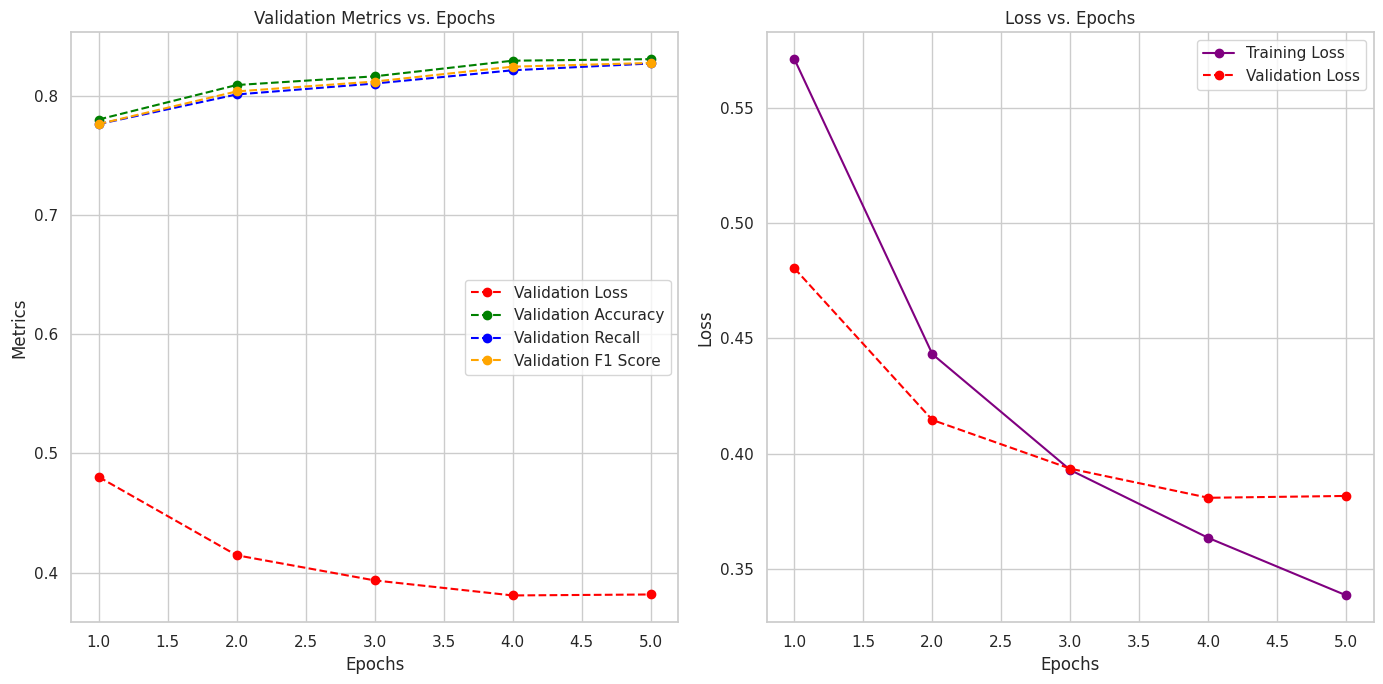

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.4804, 0.4147, 0.3936, 0.3810, 0.3818]
val_accuracy = [0.7800, 0.8089, 0.8162, 0.8293, 0.8306]
val_recall = [0.776132, 0.800985, 0.810166, 0.821257, 0.826957]
val_f1 = [0.776180, 0.803551, 0.811823, 0.824281, 0.827409]
train_loss = [0.5710, 0.4432, 0.3930, 0.3636, 0.3387]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
bert_layer2 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/1', trainable=True)

clf2 = DisasterDetector(bert_layer2, max_seq_length=128, lr=0.0001, epochs=5, batch_size=8)

clf2.train(df_train)


Fold 1

Epoch 1/5
762/762 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6596
Epoch: 1
Train Precision: 0.285796
Train Recall: 0.500000
Train F1: 0.363703
Val Precision: 0.286605
Val Recall: 0.500000
Val F1: 0.364357
762/762 [==============================] - 872s 1s/step - loss: 0.5936 - accuracy: 0.6596 - val_loss: 0.6754 - val_accuracy: 0.5732
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


762/762 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7411
Epoch: 2
Train Precision: 0.799181
Train Recall: 0.805419
Train F1: 0.797609
Val Precision: 0.794474
Val Recall: 0.800904
Val F1: 0.792843
762/762 [==============================] - 833s 1s/step - loss: 0.5239 - accuracy: 0.7411 - val_loss: 0.4715 - val_accuracy: 0.7938
Epoch 3/5
762/762 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8294
Epoch: 3
Train Precision: 0.850474
Train Recall: 0.848881
Train F1: 0.849628
Val Precision: 0.814410
Val Recall: 0.813253
Val F1: 0.813801
762/762 [==============================] - 767s 1s/step - loss: 0.4063 - accuracy: 0.8294 - val_loss: 0.4070 - val_accuracy: 0.8181
Epoch 4/5
762/762 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8506
Epoch: 4
Train Precision: 0.887069
Train Recall: 0.841326
Train F1: 0.850977
Val Precision: 0.854213
Val Recall: 0.807467
Val F1: 0.816155
762/762 [==============================] - 7

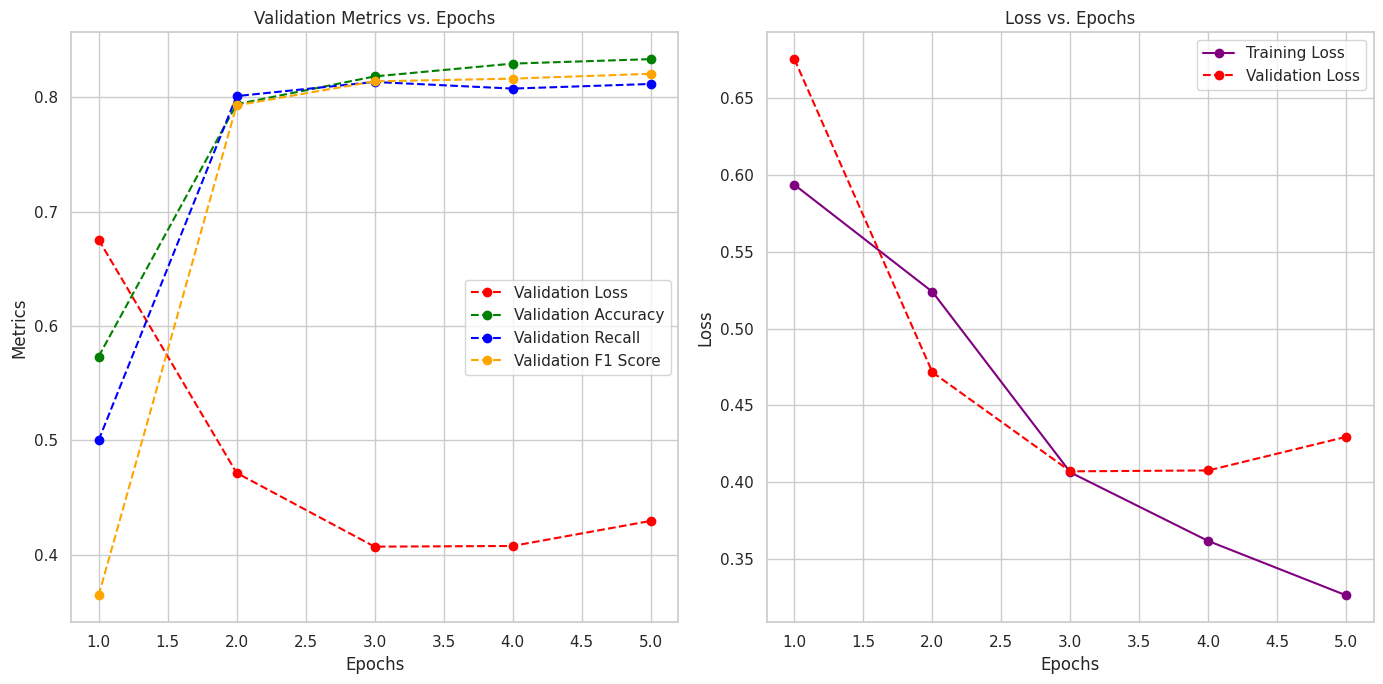

In [41]:
# Data
epochs = [1, 2, 3, 4, 5]
train_precision = [0.285796, 0.799181, 0.850474, 0.887069, 0.902190]
train_recall = [0.500000, 0.805419, 0.848881, 0.841326, 0.858763]
train_f1 = [0.363703, 0.797609, 0.849628, 0.850977, 0.868689]
val_precision = [0.286605, 0.794474, 0.814410, 0.854213, 0.858851]
val_recall = [0.500000, 0.800904, 0.813253, 0.807467, 0.811493]
val_f1 = [0.364357, 0.792843, 0.813801, 0.816155, 0.820398]
train_loss = [0.5936, 0.5239, 0.4063, 0.3616, 0.3262]
val_loss = [0.6754, 0.4715, 0.4070, 0.4076, 0.4295]
val_accuracy = [0.5732, 0.7938, 0.8181, 0.8293, 0.8332]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
bert_layer3 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/1', trainable=True)

clf3 = DisasterDetector(bert_layer3, max_seq_length=128, lr=0.0001, epochs=5, batch_size=8)

clf3.train(df_train)


Fold 1

Epoch 1/5
762/762 [==============================] - ETA: 0s - loss: 0.5313 - accuracy: 0.7401
Epoch: 1
Train Precision: 0.807548
Train Recall: 0.807634
Train F1: 0.807591
Val Precision: 0.799222
Val Recall: 0.799222
Val F1: 0.799222
762/762 [==============================] - 313s 372ms/step - loss: 0.5313 - accuracy: 0.7401 - val_loss: 0.4346 - val_accuracy: 0.8043
Epoch 2/5
762/762 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8248
Epoch: 2
Train Precision: 0.853815
Train Recall: 0.832823
Train F1: 0.838745
Val Precision: 0.831275
Val Recall: 0.810384
Val F1: 0.816532
762/762 [==============================] - 253s 332ms/step - loss: 0.4051 - accuracy: 0.8248 - val_loss: 0.4039 - val_accuracy: 0.8260
Epoch 3/5
762/762 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8456
Epoch: 3
Train Precision: 0.876482
Train Recall: 0.850601
Train F1: 0.857639
Val Precision: 0.842255
Val Recall: 0.818175
Val F1: 0.825031
762/762 [==========

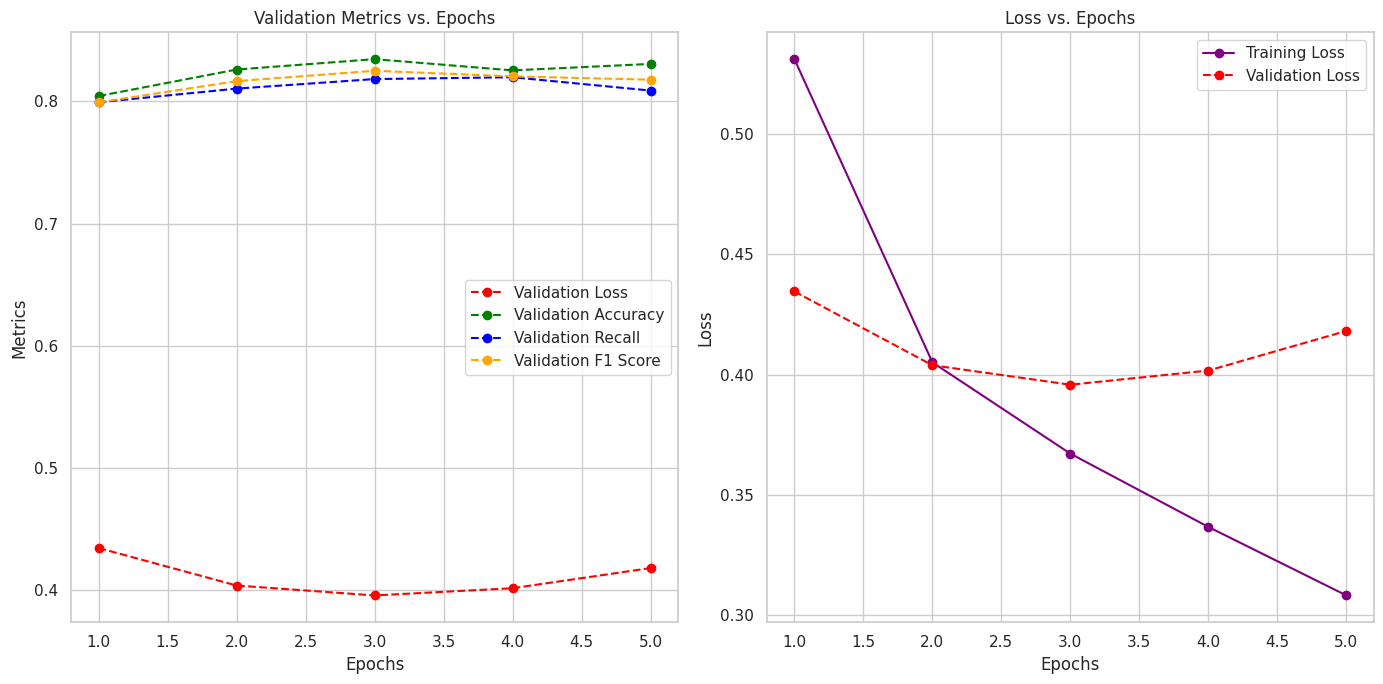

In [42]:
# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.4346, 0.4039, 0.3958, 0.4017, 0.4182]
val_accuracy = [0.8043, 0.8260, 0.8345, 0.8253, 0.8306]
val_recall = [0.7992, 0.8104, 0.8182, 0.8197, 0.8088]
val_f1 = [0.7992, 0.8165, 0.8250, 0.8204, 0.8177]
train_loss = [0.5313, 0.4051, 0.3671, 0.3366, 0.3081]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
bert_layer4 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1', trainable=True)

clf4 = DisasterDetector(bert_layer4, max_seq_length=128, lr=0.0001, epochs=5, batch_size=8)

clf4.train(df_train)


Fold 1

Epoch 1/5
762/762 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7752
Epoch: 1
Train Precision: 0.847847
Train Recall: 0.837750
Train F1: 0.841425
Val Precision: 0.829625
Val Recall: 0.815801
Val F1: 0.820090
762/762 [==============================] - 942s 1s/step - loss: 0.4782 - accuracy: 0.7752 - val_loss: 0.3989 - val_accuracy: 0.8267
Epoch 2/5
762/762 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8471
Epoch: 2
Train Precision: 0.865460
Train Recall: 0.861923
Train F1: 0.863489
Val Precision: 0.833371
Val Recall: 0.827872
Val F1: 0.830067
762/762 [==============================] - 835s 1s/step - loss: 0.3726 - accuracy: 0.8471 - val_loss: 0.3874 - val_accuracy: 0.8345
Epoch 3/5
762/762 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8663
Epoch: 3
Train Precision: 0.894805
Train Recall: 0.885746
Train F1: 0.889300
Val Precision: 0.834380
Val Recall: 0.826770
Val F1: 0.829609
762/762 [================

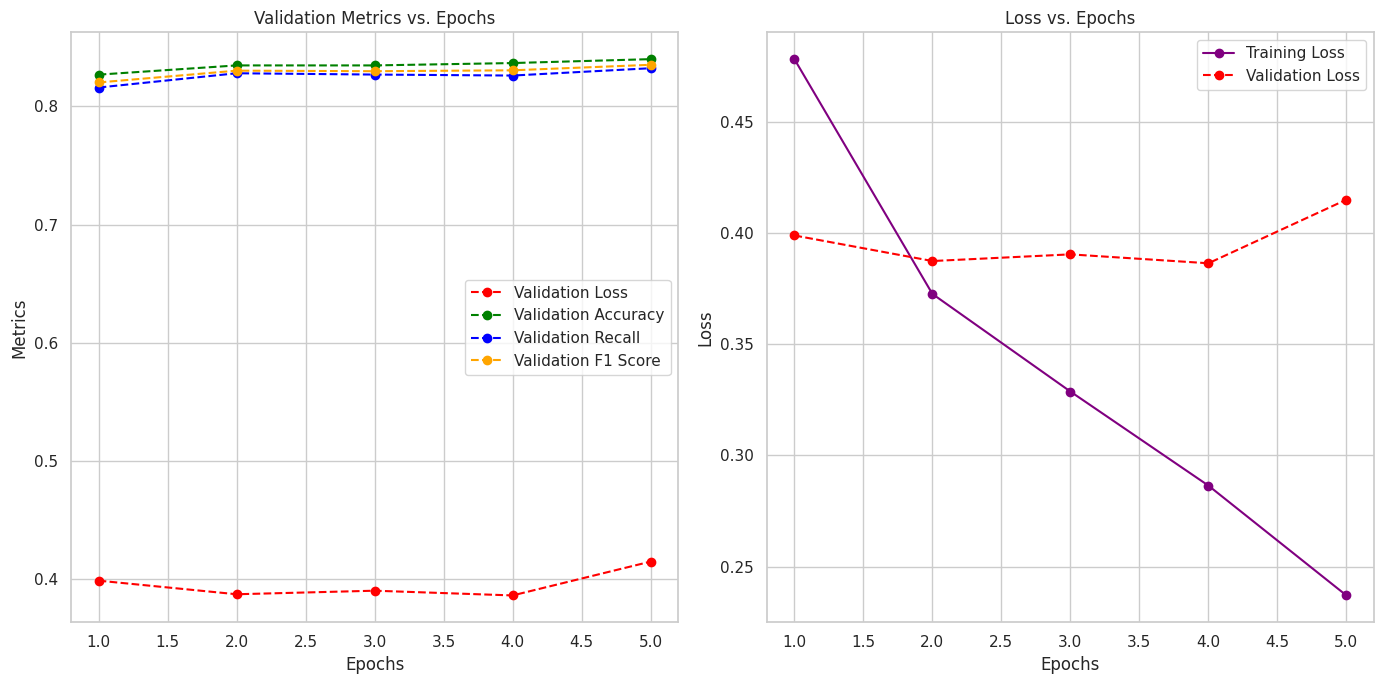

In [45]:
# Data
epochs = [1, 2, 3, 4, 5]
train_loss = [0.4782, 0.3726, 0.3287, 0.2864, 0.2370]
val_loss = [0.3989, 0.3874, 0.3904, 0.3864, 0.4150]
val_accuracy = [0.8267, 0.8345, 0.8345, 0.8365, 0.8398]
val_precision = [0.829625, 0.833371, 0.834380, 0.839966, 0.839859]
val_recall = [0.815801, 0.827872, 0.826770, 0.825930, 0.832123]
val_f1 = [0.820090, 0.830067, 0.829609, 0.830356, 0.835019]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
bert_layer5 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/1', trainable=True)

clf5 = DisasterDetector(bert_layer5, max_seq_length=128, lr=0.0001, epochs=5, batch_size=8)

clf5.train(df_train)


Fold 1

Epoch 1/5
762/762 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7798
Epoch: 1
Train Precision: 0.856256
Train Recall: 0.834474
Train F1: 0.840861
Val Precision: 0.844274
Val Recall: 0.821601
Val F1: 0.826892
762/762 [==============================] - 877s 1s/step - loss: 0.4714 - accuracy: 0.7798 - val_loss: 0.4032 - val_accuracy: 0.8339
Epoch 2/5
762/762 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8470
Epoch: 2
Train Precision: 0.859864
Train Recall: 0.863200
Train F1: 0.861269
Val Precision: 0.818028
Val Recall: 0.818523
Val F1: 0.818266
762/762 [==============================] - 806s 1s/step - loss: 0.3684 - accuracy: 0.8470 - val_loss: 0.4063 - val_accuracy: 0.8207
Epoch 3/5
762/762 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8759
Epoch: 3
Train Precision: 0.917147
Train Recall: 0.904166
Train F1: 0.909038
Val Precision: 0.840895
Val Recall: 0.827307
Val F1: 0.831283
762/762 [================

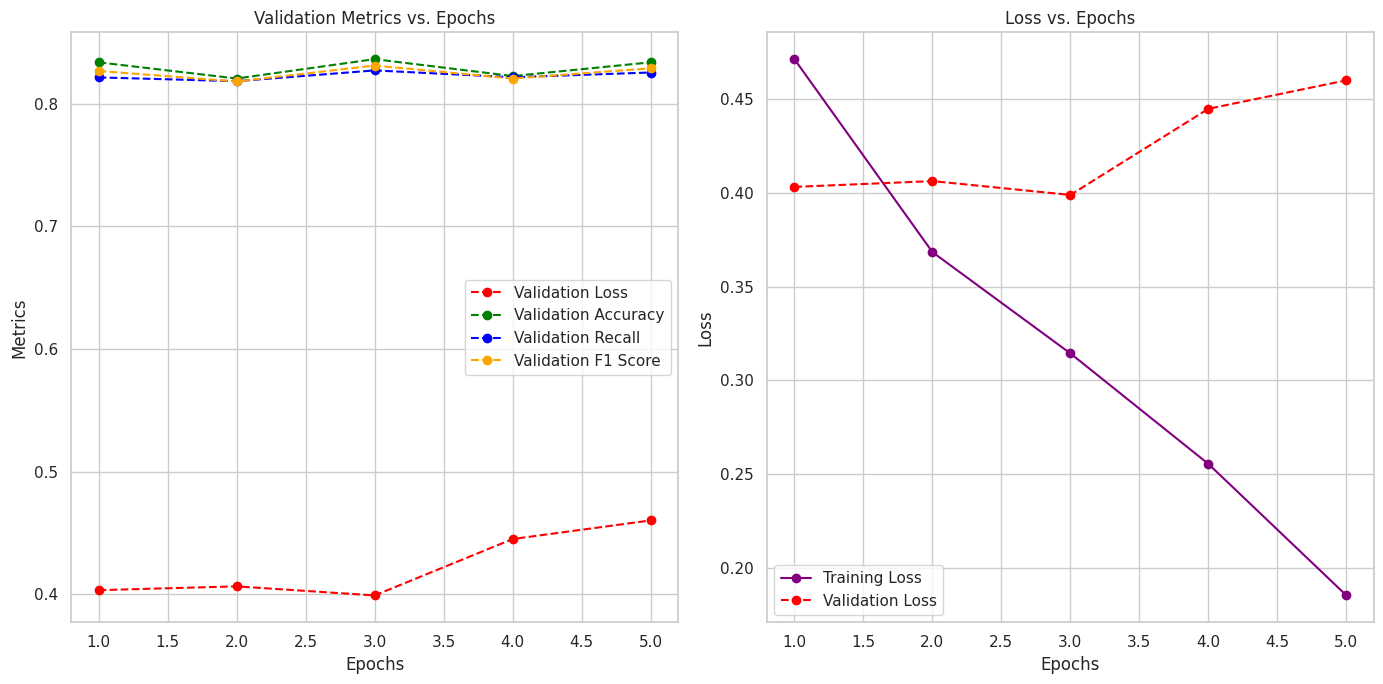

In [46]:
# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.4032, 0.4063, 0.3989, 0.4449, 0.4601]
val_accuracy = [0.8339, 0.8207, 0.8365, 0.8227, 0.8339]
val_precision = [0.844274, 0.818028, 0.840895, 0.819898, 0.836610]
val_recall = [0.821601, 0.818523, 0.827307, 0.821722, 0.825603]
val_f1 = [0.826892, 0.818266, 0.831283, 0.820664, 0.829050]
train_loss = [0.4714, 0.3684, 0.3143, 0.2553, 0.1851]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
bert_layer4 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1', trainable=True)

clf6 = DisasterDetector(bert_layer4, max_seq_length=128, lr=0.00005, epochs=5, batch_size=8)

clf6.train(df_train)


Fold 1

Epoch 1/5
762/762 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7475
Epoch: 1
Train Precision: 0.837733
Train Recall: 0.814444
Train F1: 0.820360
Val Precision: 0.826441
Val Recall: 0.797290
Val F1: 0.804866
762/762 [==============================] - 865s 1s/step - loss: 0.5145 - accuracy: 0.7475 - val_loss: 0.4401 - val_accuracy: 0.8175
Epoch 2/5
762/762 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8355
Epoch: 2
Train Precision: 0.848064
Train Recall: 0.843871
Train F1: 0.845645
Val Precision: 0.820089
Val Recall: 0.815909
Val F1: 0.817738
762/762 [==============================] - 797s 1s/step - loss: 0.3907 - accuracy: 0.8355 - val_loss: 0.4203 - val_accuracy: 0.8240
Epoch 3/5
762/762 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8534
Epoch: 3
Train Precision: 0.856934
Train Recall: 0.858037
Train F1: 0.857456
Val Precision: 0.813129
Val Recall: 0.815520
Val F1: 0.814203
762/762 [================

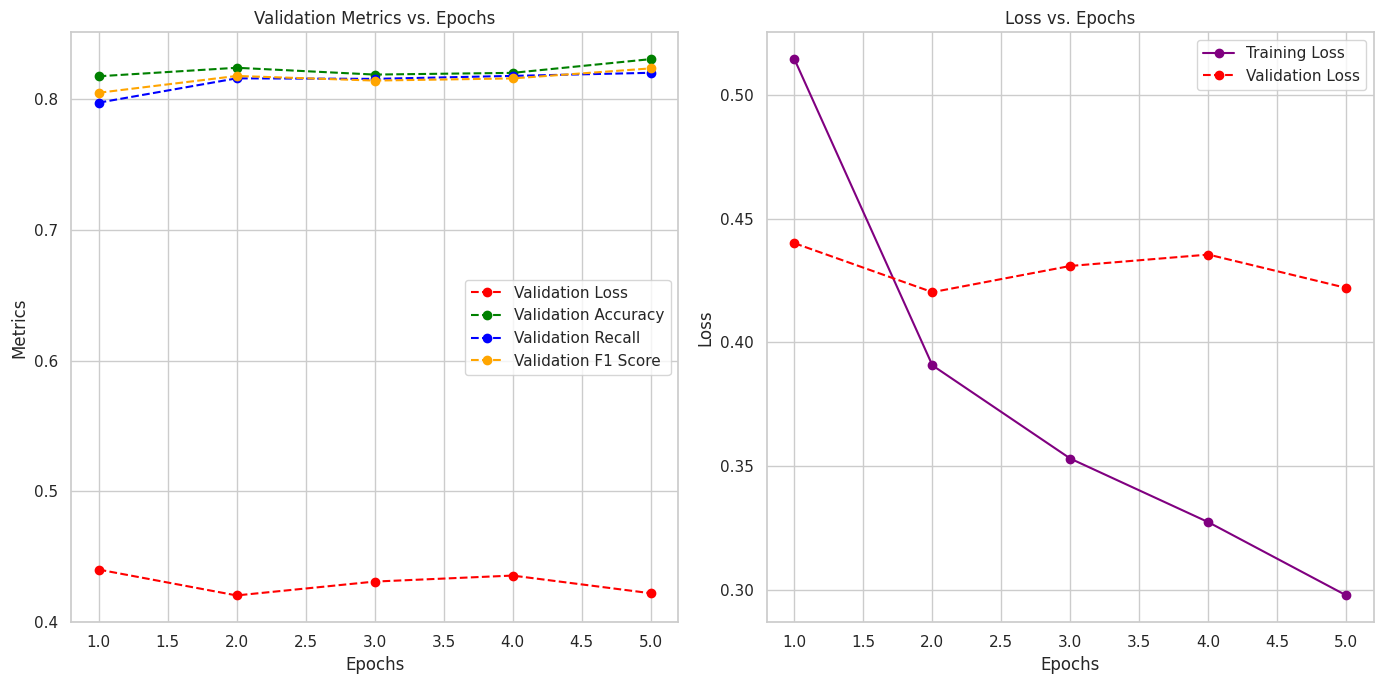

In [47]:
# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.4401, 0.4203, 0.4309, 0.4355, 0.4220]
val_accuracy = [0.8175, 0.8240, 0.8188, 0.8201, 0.8306]
val_precision = [0.826441, 0.820089, 0.813129, 0.814432, 0.828700]
val_recall = [0.797290, 0.815909, 0.815520, 0.817784, 0.820158]
val_f1 = [0.804866, 0.817738, 0.814203, 0.815856, 0.823520]
train_loss = [0.5145, 0.3907, 0.3530, 0.3273, 0.2977]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [29]:
bert_layer4 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1', trainable=True)

clf7 = DisasterDetector(bert_layer4, max_seq_length=128, lr=0.0001, epochs=5, batch_size=16)

clf7.train(df_train)


Fold 1

Epoch 1/5
381/381 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.7312
Epoch: 1
Train Precision: 0.813131
Train Recall: 0.810568
Train F1: 0.811701
Val Precision: 0.795367
Val Recall: 0.789406
Val F1: 0.791790
381/381 [==============================] - 854s 2s/step - loss: 0.5469 - accuracy: 0.7312 - val_loss: 0.4618 - val_accuracy: 0.7991
Epoch 2/5
381/381 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8268
Epoch: 2
Train Precision: 0.859471
Train Recall: 0.820835
Train F1: 0.828848
Val Precision: 0.833351
Val Recall: 0.787490
Val F1: 0.796192
381/381 [==============================] - 790s 2s/step - loss: 0.4101 - accuracy: 0.8268 - val_loss: 0.4389 - val_accuracy: 0.8122
Epoch 3/5
381/381 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8473
Epoch: 3
Train Precision: 0.877300
Train Recall: 0.857768
Train F1: 0.863717
Val Precision: 0.835876
Val Recall: 0.811822
Val F1: 0.818605
381/381 [================

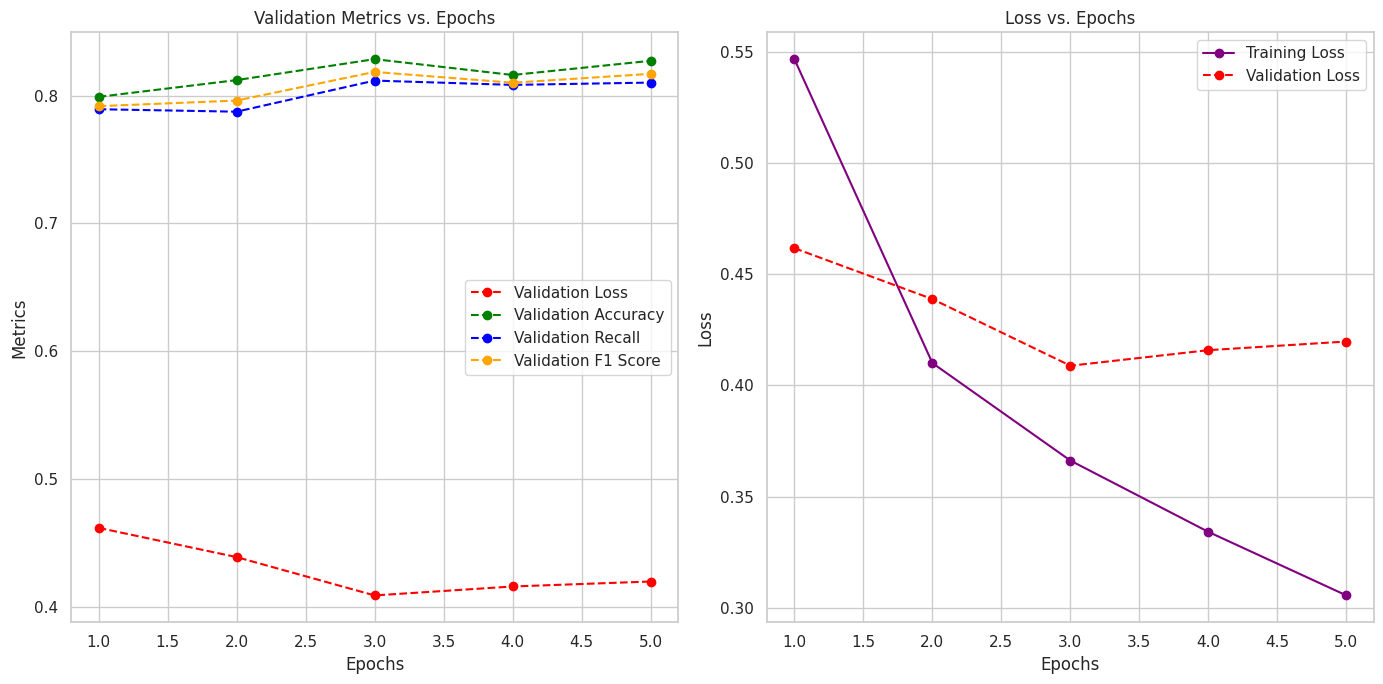

In [48]:
# Data
epochs = [1, 2, 3, 4, 5]
train_loss = [0.5469, 0.4101, 0.3662, 0.3341, 0.3055]
val_loss = [0.4618, 0.4389, 0.4089, 0.4159, 0.4198]
val_accuracy = [0.7991, 0.8122, 0.8286, 0.8162, 0.8273]
val_precision = [0.795367, 0.833351, 0.835876, 0.812345, 0.834795]
val_recall = [0.789406, 0.787490, 0.811822, 0.808449, 0.810257]
val_f1 = [0.791790, 0.796192, 0.818605, 0.810141, 0.817095]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [30]:
bert_layer4 = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1', trainable=True)

clf8 = DisasterDetector(bert_layer4, max_seq_length=128, lr=0.00005, epochs=5, batch_size=16)

clf8.train(df_train)


Fold 1

Epoch 1/5
381/381 [==============================] - ETA: 0s - loss: 0.5864 - accuracy: 0.6857
Epoch: 1
Train Precision: 0.786604
Train Recall: 0.780791
Train F1: 0.782986
Val Precision: 0.784488
Val Recall: 0.770798
Val F1: 0.774883
381/381 [==============================] - 822s 2s/step - loss: 0.5864 - accuracy: 0.6857 - val_loss: 0.4829 - val_accuracy: 0.7846
Epoch 2/5
381/381 [==============================] - ETA: 0s - loss: 0.4488 - accuracy: 0.8002
Epoch: 2
Train Precision: 0.825088
Train Recall: 0.814083
Train F1: 0.817810
Val Precision: 0.806090
Val Recall: 0.794505
Val F1: 0.798375
381/381 [==============================] - 724s 2s/step - loss: 0.4488 - accuracy: 0.8002 - val_loss: 0.4311 - val_accuracy: 0.8063
Epoch 3/5
381/381 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8278
Epoch: 3
Train Precision: 0.853946
Train Recall: 0.821554
Train F1: 0.829015
Val Precision: 0.834715
Val Recall: 0.797428
Val F1: 0.805218
381/381 [================

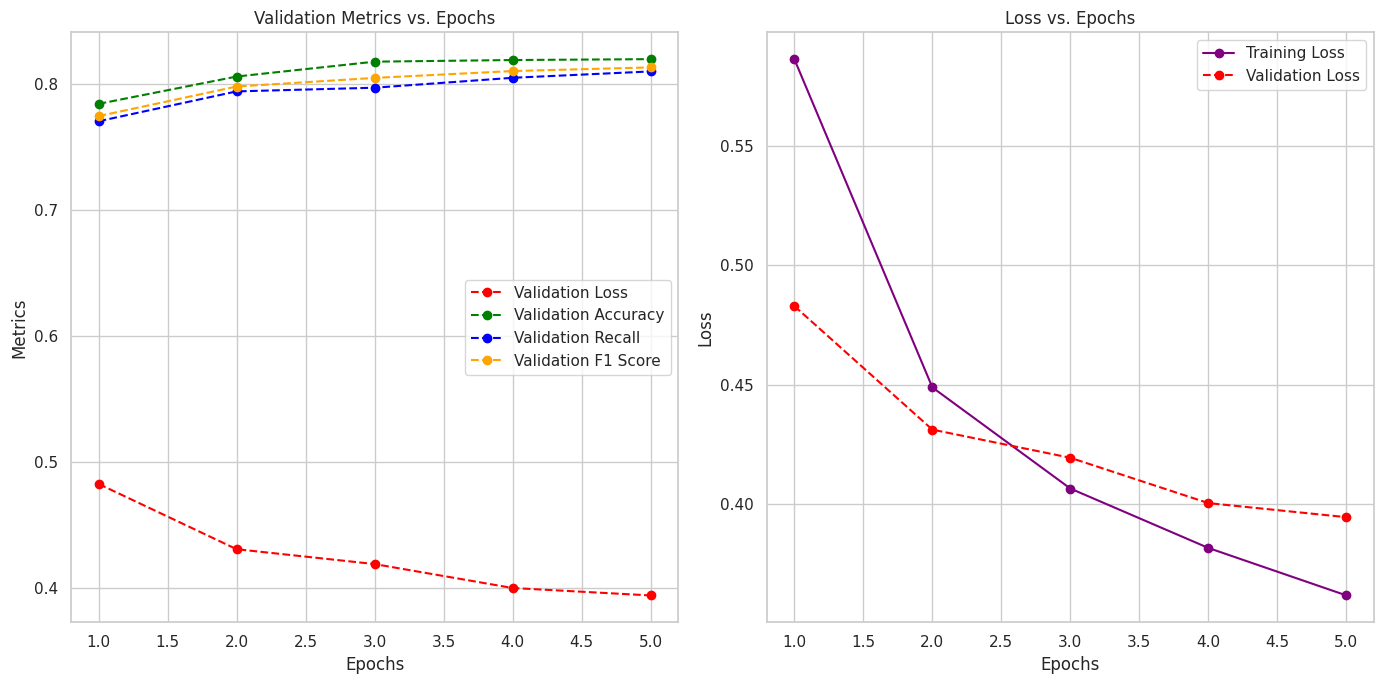

In [49]:
# Data
epochs = [1, 2, 3, 4, 5]
val_loss = [0.4829, 0.4311, 0.4193, 0.4003, 0.3944]
val_accuracy = [0.7846, 0.8063, 0.8181, 0.8194, 0.8201]
val_recall = [0.770798, 0.794505, 0.797428, 0.805296, 0.810351]
val_f1 = [0.774883, 0.798375, 0.805218, 0.810653, 0.813563]
train_loss = [0.5864, 0.4488, 0.4064, 0.3815, 0.3616]

# Plotting Validation metrics
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', linestyle='--', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', color='blue', linestyle='--', marker='o')
plt.plot(epochs, val_f1, label='Validation F1 Score', color='orange', linestyle='--', marker='o')
plt.title('Validation Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='purple', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [31]:
y_pred = clf4.predict(df_test)

102/102 [==============================] - 91s 896ms/step


In [40]:
path = '/content/drive/My Drive/CSCI594/Project/model_submission.csv'

model_submission = pd.read_csv("/content/drive/My Drive/CSCI594/Project/submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv(path, index=False)
model_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.357646
std,3146.427221,0.479381
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
